## Simple Mie Phase function tutorial
This is just the first test, more to follow. 

---
In the following, we will just walk through how to compute greek coefficients (which will be require for radiative transfer calculations) as well as actual phase matrices from the Mie theory.

---
First let's use the required packages

In [2]:
using Revise
using RadiativeTransfer.PhaseFunction
using Distributions
using Plots

┌ Info: Precompiling RadiativeTransfer [ace8185b-fa20-42f5-912d-1e850dbe6a09]
└ @ Base loading.jl:1278


In [3]:
# Aerosol particle distribution and properties 
μ  = 0.1        # Log-normal median radius [μm]
σ  = 1.13        # Log-normal stddev of radius
r_max = 30.0    # Maximum radius [μm]
n  = 2500       # Number of quadrature points for integrating of size dist.
nᵣ = 1.45        # Real part of refractive index
nᵢ = 0.001       # Imag part of refractive index (sign changed, use only + here)

# Create a Size Distribution (from Julia's Distributions package)
size_distribution = LogNormal(log(μ), log(σ))

# Create the aerosol
aero = make_univariate_aerosol(size_distribution, r_max, n, nᵣ, nᵢ)

UnivariateAerosol{Float64,Float64}(LogNormal{Float64}(μ=-2.3025850929940455, σ=0.12221763272424911), 30.0, 2500, 1.45, 0.001)

In [4]:
λ = 0.77                             # Incident wavelength [μm]
polarization_type = Stokes_IQUV()    # Polarization type 
truncation_type   = δBGE(70, 2.0)      # Truncation type

δBGE{Float64}(70, 2.0)

In [5]:
# Create a Mie model, using the Siewert method NAI2
model_NAI2 = make_mie_model(NAI2(), aero, λ, polarization_type, truncation_type)

MieModel{NAI2}
  computation_type: NAI2 NAI2()
  aerosol: UnivariateAerosol{Float64,Float64}
  λ: Float64 0.77
  polarization_type: Stokes_IQUV Stokes_IQUV()
  truncation_type: δBGE{Float64}
  wigner_A: Array{Float64}((1, 1, 1)) [0.0]
  wigner_B: Array{Float64}((1, 1, 1)) [0.0]


In [6]:
# Compute aerosol optical properties:
aerosol_optics_NAI2 = compute_aerosol_optical_properties(model_NAI2);

┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
Computing PhaseFunctions Siewert NAI-2 style ...100%|███| Time: 0:00:02


--- 
simple example of how to use the Documentation, add `?` in front and get the DocStrings of aerosol_optics_NAI2 :


In [7]:
@info "Fraction of size distribution cut by max radius: $((1-cdf.(size_distribution,r_max))*100) %"

┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ Main In[7]:1


In [8]:
?aerosol_optics_NAI2

search: aerosol_optics_NAI2 compute_aerosol_optical_properties



No documentation found.

`aerosol_optics_NAI2` is of type `AerosolOptics{Float64}`.

# Summary

```
struct AerosolOptics{Float64} <: Any
```

# Fields

```
greek_coefs :: GreekCoefs
ω̃          :: Float64
k           :: Float64
fᵗ          :: Any
derivs      :: Any
```


---
### Let's plot the greek coefficients
which are basically giving us the legendre decomposition of the phase matrix components:

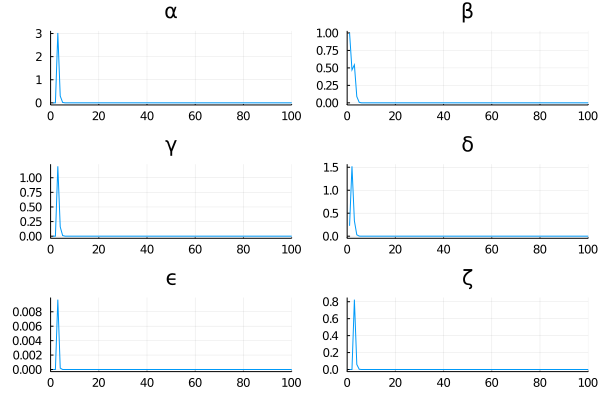

In [9]:
using Parameters
@unpack α,β,γ,δ,ϵ,ζ = aerosol_optics_NAI2.greek_coefs
p1 = plot(α,  title="α")
p2 = plot(β,  title="β")
p3 = plot(γ,  title="γ")
p4 = plot(δ,  title="δ")
p5 = plot(ϵ,  title="ϵ")
p6 = plot(ζ,  title="ζ")
plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), legend=false)
xlims!(0,100)

In [10]:
using FastGaussQuadrature
μ, w_μ = gausslegendre(1000)
# Reconstruct Phase Functions from greek coefficients (overkill for Siewert, mostly for Wigner method)
f₁₁, f₁₂, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2.greek_coefs, μ);

---
#### Plot only phase function for I (f₁₁) and the I -> Q transition in the phase matrix (f₁₂) for the Stokes Vector [I,Q,U,V]

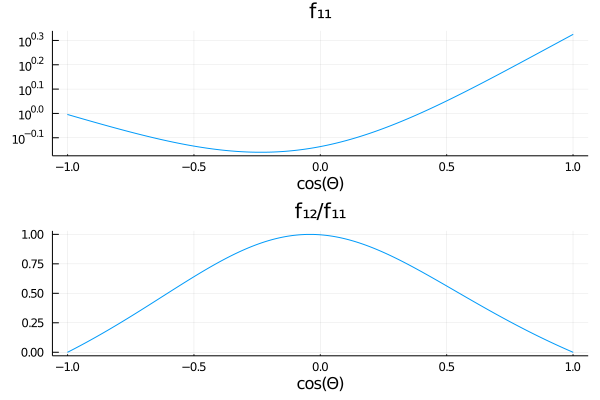

In [11]:

p1 = plot(μ, f₁₁, yscale=:log10, title="f₁₁")
p2 = plot(μ, f₁₂ ./ f₁₁,  title="f₁₂/f₁₁")

plot(p1, p2, layout=(2, 1), legend=false)
xlabel!("cos(Θ)")

In [12]:
anim = @animate for r = 0.1:0.05:1.0
    local size_distribution = LogNormal(log(r), log(1.13))
    # Create the aerosol
    local aero            = make_univariate_aerosol(size_distribution, r_max, n, nᵣ, nᵢ)
    local model_NAI2_760  = make_mie_model(NAI2(), aero, 0.76, polarization_type, truncation_type)
    local model_NAI2_1600 = make_mie_model(NAI2(), aero, 1.6, polarization_type, truncation_type)
    local model_NAI2_2060 = make_mie_model(NAI2(), aero, 2.06, polarization_type, truncation_type)
    local aerosol_optics_NAI2_760  = compute_aerosol_optical_properties(model_NAI2_760);
    local aerosol_optics_NAI2_1600 = compute_aerosol_optical_properties(model_NAI2_1600);
    local aerosol_optics_NAI2_2060 = compute_aerosol_optical_properties(model_NAI2_2060);
    local f₁₁_760, f₁₂_760, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2_760.greek_coefs, μ);
    local f₁₁_1600, f₁₂_1600, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2_1600.greek_coefs, μ);
    local f₁₁_2060, f₁₂_2060, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2_2060.greek_coefs, μ);
    # @show f₁₁[1]
    p1 = plot(acosd.(μ), [f₁₁_760,f₁₁_1600,f₁₁_2060], yscale=:log10, title="f₁₁, r(μm)=$r", label=["760nm" "1600nm" "2060nm"], lw=2, legend=:topleft, size = (600, 400))
    ylims!(5e-2, 2e0)
    xlims!(120,180)
    p2 = plot(acosd.(μ), [f₁₂_760  ./ f₁₁_760,f₁₂_1600 ./ f₁₁_1600,f₁₂_2060 ./ f₁₁_2060] , legend=false, title="f₁₂/f₁₁",lw=2, size = (600, 400))
    ylims!(-1.1, 1.1)
    xlims!(120,180)
    plot(p1, p2, layout=(2, 1))
end

┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
Computing PhaseFunctions Siewert NAI-2 style ...100%|███| Time: 0:00:01
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
Computing PhaseFunctions Siewert NAI-2 style ...100%|███| Time: 0:00:01
┌ Info: Fraction of size distribution cut by max rad

Animation("/var/folders/fb/yk9msnt958vf1qqnkv9jjnp00000gq/T/jl_d0bh3T", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png", "000012.png", "000013.png", "000014.png", "000015.png", "000016.png", "000017.png", "000018.png", "000019.png"])

In [21]:
anim2 = @animate for r = 0.06:0.03:1.0
    local size_distribution = LogNormal(log(r), log(1.13))
    # Create the aerosol
    local aero            = make_univariate_aerosol(size_distribution, r_max, n, nᵣ, nᵢ)
    local model_NAI2_760  = make_mie_model(NAI2(), aero, 0.76, polarization_type, truncation_type)
    local model_NAI2_1600 = make_mie_model(NAI2(), aero, 1.6, polarization_type, truncation_type)
    local model_NAI2_2060 = make_mie_model(NAI2(), aero, 2.06, polarization_type, truncation_type)
    local aerosol_optics_NAI2_760  = compute_aerosol_optical_properties(model_NAI2_760);
    local aerosol_optics_NAI2_1600 = compute_aerosol_optical_properties(model_NAI2_1600);
    local aerosol_optics_NAI2_2060 = compute_aerosol_optical_properties(model_NAI2_2060);
    local f₁₁_760, f₁₂_760, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2_760.greek_coefs, μ);
    local f₁₁_1600, f₁₂_1600, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2_1600.greek_coefs, μ);
    local f₁₁_2060, f₁₂_2060, f₂₂, f₃₃, f₃₄, f₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2_2060.greek_coefs, μ);
    # @show f₁₁[1]
    p1 = plot(acosd.(μ), [f₁₁_760,f₁₁_1600,f₁₁_2060], yscale=:log10, title="f₁₁, r(μm)=$r", label=["760nm" "1600nm" "2060nm"], lw=2, legend=:topright, size = (600, 400))
    ylims!(5e-2, 2e2)
    xlims!(0,180)
    p2 = plot(acosd.(μ), [f₁₂_760  ./ f₁₁_760,f₁₂_1600 ./ f₁₁_1600,f₁₂_2060 ./ f₁₁_2060] , legend=false, title="f₁₂/f₁₁",lw=2, size = (600, 400))
    ylims!(-1.1, 1.1)
    xlims!(0,180)
    plot(p1, p2, layout=(2, 1))
end

 RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
Computing PhaseFunctions Siewert NAI-2 style ...100%|███| Time: 0:00:01
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
┌ Info: Fraction of size distribution cut by max radius: 0.0 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functi

Animation("/var/folders/fb/yk9msnt958vf1qqnkv9jjnp00000gq/T/jl_ETuC1z", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000023.png", "000024.png", "000025.png", "000026.png", "000027.png", "000028.png", "000029.png", "000030.png", "000031.png", "000032.png"])

┌ Info: Saved animation to 
│   fn = /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/Notebooks/tmp.gif
└ @ Plots /Users/sanghavi/.julia/packages/Plots/YdauZ/src/animation.jl:104


Plots.AnimatedGif("/Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/Notebooks/tmp.gif")
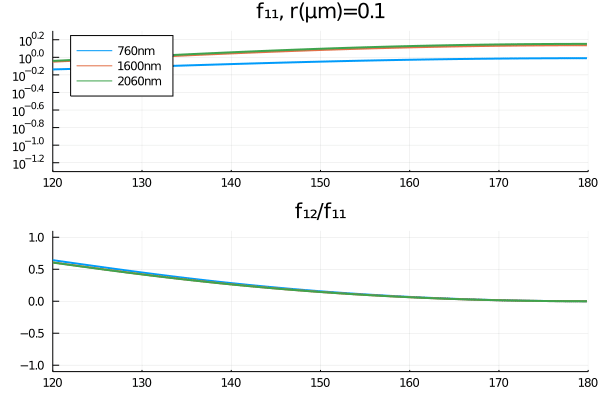

In [14]:
gif(anim, fps = 3)

┌ Info: Saved animation to 
│   fn = /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/Notebooks/tmp.gif
└ @ Plots /Users/sanghavi/.julia/packages/Plots/YdauZ/src/animation.jl:104


Plots.AnimatedGif("/Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/Notebooks/tmp.gif")
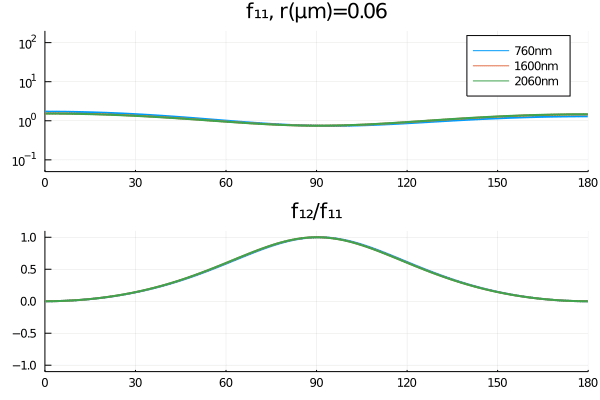

In [22]:
gif(anim2, fps = 3)

In [24]:
using DelimitedFiles

S1=readdlm("/Users/sanghavi/GDrive/presentations/phase_r0p1_775nm.dat", ' ')
mu_A=S1[:,2]
f11_A=zeros(2,length(mu_A))
f44_A=zeros(2,length(mu_A))
f12_A=zeros(2,length(mu_A))
f34_A=zeros(2,length(mu_A))
f11_A[1,:]=S1[:,3]
f44_A[1,:]=S1[:,4]
f12_A[1,:]=S1[:,5]
f34_A[1,:]=S1[:,6]
S2=readdlm("/Users/sanghavi/GDrive/presentations/phase_r0p5_775nm.dat", ' ')
mu_A=S2[:,2]
f11_A[2,:]=S2[:,3]
f44_A[2,:]=S2[:,4]
f12_A[2,:]=S2[:,5]
f34_A[2,:]=S2[:,6]
S1=readdlm("/Users/sanghavi/GDrive/presentations/phase_r0p1_1605nm.dat", ' ')
mu_B=S1[:,2]
f11_B=zeros(2,length(mu_B))
f44_B=zeros(2,length(mu_B))
f12_B=zeros(2,length(mu_B))
f34_B=zeros(2,length(mu_B))
f11_B[1,:]=S1[:,3]
f44_B[1,:]=S1[:,4]
f12_B[1,:]=S1[:,5]
f34_B[1,:]=S1[:,6]
S1=readdlm("/Users/sanghavi/GDrive/presentations/phase_r0p5_1605nm.dat", ' ')
mu_B=S1[:,2]
f11_B[2,:]=S1[:,3]
f44_B[2,:]=S1[:,4]
f12_B[2,:]=S1[:,5]
f34_B[2,:]=S1[:,6]
S1=readdlm("/Users/sanghavi/GDrive/presentations/phase_r0p1_2060nm.dat", ' ')
mu_C=S1[:,2]
f11_C=zeros(2,length(mu_C))
f44_C=zeros(2,length(mu_C))
f12_C=zeros(2,length(mu_C))
f34_C=zeros(2,length(mu_C))
f11_C[1,:]=S1[:,3]
f44_C[1,:]=S1[:,4]
f12_C[1,:]=S1[:,5]
f34_C[1,:]=S1[:,6]
S1=readdlm("/Users/sanghavi/GDrive/presentations/phase_r0p5_2060nm.dat", ' ')
mu_C=S1[:,2]
f11_C[2,:]=S1[:,3]
f44_C[2,:]=S1[:,4]
f12_C[2,:]=S1[:,5]
f34_C[2,:]=S1[:,6]

221-element Array{Float64,1}:
  6.57725e-6
  3.46394e-5
  8.50609e-5
  0.000157743
  0.000252528
  0.000369209
  0.000507531
  0.000667189
  0.000847833
  0.00104906
  0.00127044
  0.00151146
  0.00177161
  ⋮
 -0.00496232
 -0.0041703
 -0.00344312
 -0.00278231
 -0.00218925
 -0.00166521
 -0.00121128
 -0.000828429
 -0.000517456
 -0.000279021
 -0.000113623
 -2.15741e-5

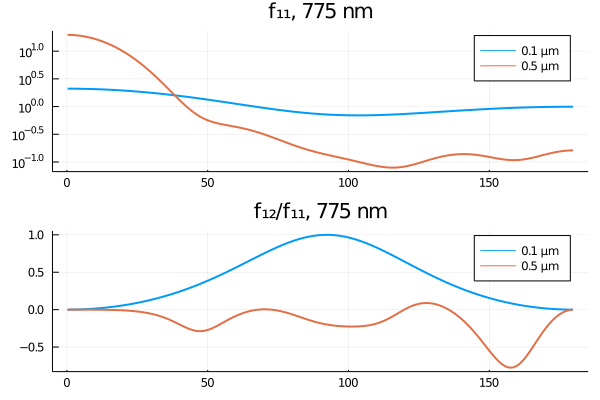

In [40]:
p1 = plot(acosd.(mu_A), [f11_A[1,:],f11_A[2,:]], yscale=:log10, title="f₁₁, 775 nm", label=["0.1 μm" "0.5 μm"], lw=2, legend=:topright, size = (600, 400))
p11 = plot(acosd.(mu_A), [f12_A[1,:]./f11_A[1,:],f12_A[2,:]./f11_A[2,:]], title="f₁₂/f₁₁, 775 nm", label=["0.1 μm" "0.5 μm"], lw=2, legend=:topright, size = (600, 400))
plot(p1, p11, layout=(2, 1))
#savefig("phase775.pdf")

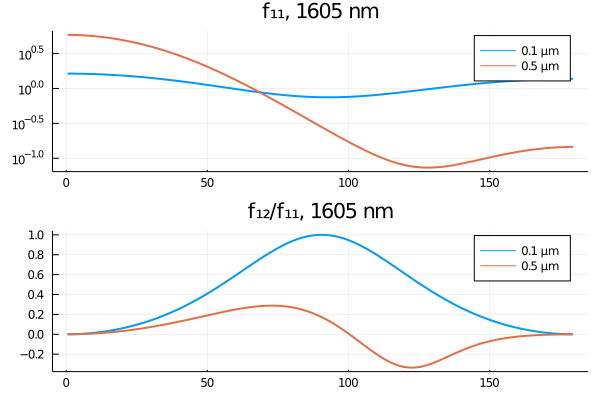

In [41]:
p2 = plot(acosd.(mu_B), [f11_B[1,:],f11_B[2,:]], yscale=:log10, title="f₁₁, 1605 nm", label=["0.1 μm" "0.5 μm"], lw=2, legend=:topright, size = (600, 400))
p21 = plot(acosd.(mu_B), [f12_B[1,:]./f11_B[1,:],f12_B[2,:]./f11_B[2,:]], title="f₁₂/f₁₁, 1605 nm", label=["0.1 μm" "0.5 μm"], lw=2, legend=:topright, size = (600, 400))
plot(p2, p21, layout=(2, 1))
#savefig("phase1605.pdf")

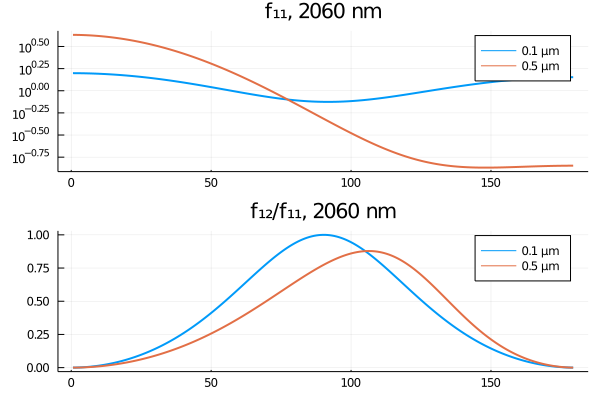

In [42]:
p3 = plot(acosd.(mu_C), [f11_C[1,:],f11_C[2,:]], yscale=:log10, title="f₁₁, 2060 nm", label=["0.1 μm" "0.5 μm"], lw=2, legend=:topright, size = (600, 400))
p31 = plot(acosd.(mu_C), [f12_C[1,:]./f11_C[1,:],f12_C[2,:]./f11_C[2,:]], title="f₁₂/f₁₁, 2060 nm", label=["0.1 μm" "0.5 μm"], lw=2, legend=:topright, size = (600, 400))
plot(p3, p31, layout=(2, 1))
#savefig("phase2060.pdf")

In [48]:
#pgfplotsx()
gr()

Plots.GRBackend()

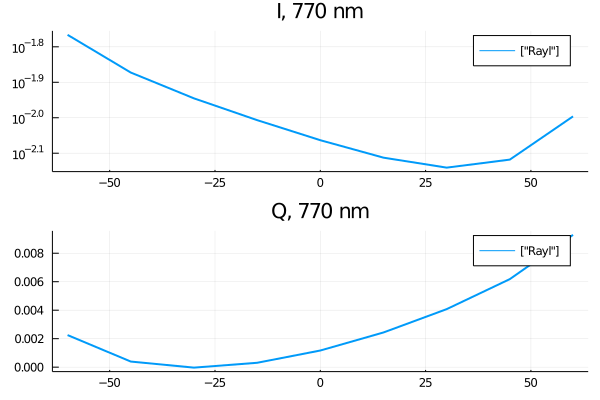

In [52]:
S1=readdlm("Rayl_orig.dat", ' ')
vza=[-60. -45. -30. -15. 0. 15. 30. 45. 60.]
I_rayl0=S1[:,1]
Q_rayl0=S1[:,2]
U_rayl0=S1[:,3]
V_rayl0=S1[:,4]
p1 = plot(vza', [I_rayl0], yscale=:log10, title="I, 770 nm", label=["Rayl"], lw=2, legend=:topright, size = (600, 400))
p2 = plot(vza', [Q_rayl0], title="Q, 770 nm", label=["Rayl"], lw=2, legend=:topleft, size = (600, 400))
plot(p1, p2, layout=(2, 1))
